In this exercise, we are going to implement a [UNet-like](https://arxiv.org/pdf/1505.04597.pdf) architecture for the semantic segmentation task.
The model is trained on the [CamVid](https://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/) dataset.

Tasks:

1. Implement the missing pieces in the code.
2. Check that the given implementation reaches over 70% test accuracy after 10-15 epochs.
3. Check how segmentations produced by the model compare to ground truth segementations.

On Colab GPU training should take \~5s per epoch
(\~40s for the first epoch, where we apply and cache data transformations).

In [1]:
import shutil
from collections.abc import Callable
from pathlib import Path
from typing import TypedDict

import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import PIL.ImagePalette
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
from torchvision.datasets.utils import download_url, download_and_extract_archive
from torchvision.transforms import v2
from torchvision.transforms.functional import InterpolationMode
from tqdm import tqdm


## Building blocks of a UNet

In [2]:
def make_unet_block(in_channels: int, out_channels: int) -> nn.Module:
    """
    Make a UNet convolutional block.

    Input of block: shape (B, in_channels, Hᵢ, Wᵢ).
    Output of block: shape (B, out_channels, Hᵢ, Wᵢ).
    """
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(),
    )

def make_encoder_block(in_channels: int, out_channels: int, use_maxpool: bool = True) -> nn.Module:
    """
    Make an encoder block for UNet.

    Input of block: shape (B, in_channels, Hᵢ, Wᵢ).
    Output of block: shape (B, out_channels, Hᵢ/2, Wᵢ/2) if use_maxpool is True, same as input otherwise.
    """
    result = nn.Sequential()
    if use_maxpool:
        result.add_module("maxpool", nn.MaxPool2d((2, 2)))
    result.add_module("conv1", make_unet_block(in_channels, out_channels))
    result.add_module("conv2", make_unet_block(out_channels, out_channels))
    return result

In [3]:
class DecoderBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__()
        self.upsample = nn.ConvTranspose2d(
            in_channels, in_channels, kernel_size=3, stride=2, padding=1
        )
        self.up = nn.Sequential(
            make_unet_block(in_channels + out_channels, out_channels),
            make_unet_block(out_channels, out_channels),
        )

    def forward(self, x: Tensor, y: Tensor) -> Tensor:
        """
        Input:
        - x: output of previous decoder layer, shape (B, in_channels, Hᵢ/2, Wᵢ/2).
        - y: output of corresponding encoder layer, shape (B, out_channels, Hᵢ, Wᵢ).

        Output: shape (B, out_channels, Hᵢ, Wᵢ).
        """
        x = self.upsample(x)

        diff_h = y.size(2) - x.size(2)
        diff_w = y.size(3) - x.size(3)
        
        x = F.pad(x, [diff_w // 2, diff_w - diff_w // 2,
                diff_h // 2, diff_h - diff_h // 2])
    
        x = torch.cat([y, x], dim=1)

        x = self.up(x)

        return x

## UNet

In [4]:
class UNet(nn.Module):
    def __init__(self, encoder_channels: list[int], decoder_channels: list[int], num_classes: int) -> None:
        super().__init__()

        self.encoder = nn.ModuleList()
        encoder_sizes = zip(encoder_channels[:-1], encoder_channels[1:], strict=True)
        for idx, (in_size, out_size) in enumerate(encoder_sizes):
            if idx == 0:
                self.encoder.append(make_encoder_block(in_size, out_size, use_maxpool=False))
            else:
                self.encoder.append(make_encoder_block(in_size, out_size))

        self.decoder = nn.ModuleList()
        decoder_sizes = zip(decoder_channels[:-1], decoder_channels[1:], strict=True)
        for in_size, out_size in decoder_sizes:
            self.decoder.append(DecoderBlock(in_size, out_size))

        self.conv = nn.Conv2d(
            decoder_channels[-1], num_classes, kernel_size=3, padding=1
        )

    def forward(self, x: Tensor) -> Tensor:
        """
        Input: image of shape (B, C=3, H, W).
        Output: logits (not softmaxed) of shape (B, num_classes, H, W).
        """
        # TODO: implement UNet's forward pass.
        # hint: Remember to store outputs of subsequent
        # encoder layers to use as input to decoder layers!
        # Do not forget about the final convolution.

        encoder_outputs = []
        for encoder_layer in self.encoder:
            x = encoder_layer(x)
            encoder_outputs.append(x.clone())

        for decoder_layer, y in zip(self.decoder, encoder_outputs[::-1][1:]):
            x = decoder_layer(x, y)
        
        x = self.conv(x)

        return x

## Train and test

In [5]:
def train(
    model: torch.nn.Module,
    device: torch.device,
    train_loader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    epoch: int,
    log_interval: int,
) -> None:
    model.train()
    correct = 0
    progress_bar = tqdm(
        enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch}"
    )
    for batch_idx, (image, target) in progress_bar:
        image, target = image.to(device), target.to(device)
        B, C, H, W = image.size()
        optimizer.zero_grad()
        output = model(image)  # shape: (B, num_classes, H, W)
        log_probs = F.log_softmax(output, dim=1)
        loss = F.nll_loss(log_probs, target.squeeze(dim=1))
        # Or just `loss = F.cross_entropy(output, target.squeeze(dim=1))`
        pred = log_probs.argmax(dim=1)
        correct += (pred == target.squeeze(dim=1)).sum().item()
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            progress_bar.set_postfix(loss=loss.item())

    total_pixels = len(train_loader.dataset) * H * W
    print(f"Train accuracy: {correct}/{total_pixels} ({correct / total_pixels:.1%})")


def test(
    model: torch.nn.Module,
    device: torch.device,
    test_loader: torch.utils.data.DataLoader,
) -> None:
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for image, target in test_loader:
            B, C, H, W = image.size()
            image, target = image.to(device), target.to(device)
            output = model(image)
            log_probs = F.log_softmax(output, dim=1)
            test_loss += F.nll_loss(log_probs, target.squeeze(dim=1), reduction="sum").item()
            pred = log_probs.argmax(dim=1)
            correct += (pred == target.squeeze(dim=1)).sum().item()

    total_pixels = len(test_loader.dataset) * H * W
    test_loss /= total_pixels

    print(
        f"Test loss: {test_loss:.4f}, accuracy: {correct}/{total_pixels} ({correct / total_pixels:.1%})"
    )

## SegmentationDataset

In [6]:
data_root = Path("../data/camvid")

In [7]:
class SegmentationDatasetDownloader:
    """Downloader for the camvid segmentation dataset."""

    def __init__(self, root_dir: Path) -> None:
        self.root_dir = root_dir
        # self.download()

    def download(self) -> None:
        labels_md5 = "c23b65a6ce2812285d45e4ff015b873b"
        images_md5 = "376aec8caa43536e90a5dd766bd95981"
        segmentations_md5 = "d0b6f83acea3bc5a12ea0a4d6fc267a8"
        download_url(
            url="https://datasets.cms.waikato.ac.nz/ufdl/data/camvid/label_colors.txt",
            root=self.root_dir,
            filename="label_colors.txt",
            md5=labels_md5,
        )
        download_and_extract_archive(
            url="https://datasets.cms.waikato.ac.nz/ufdl/data/camvid/LabeledApproved_full.zip",
            download_root=self.root_dir,
            extract_root=self.root_dir / "segmentations",
            filename="segmentations.zip",
            md5=segmentations_md5,
            remove_finished=False,
        )
        download_and_extract_archive(
            url="https://datasets.cms.waikato.ac.nz/ufdl/data/camvid/701_StillsRaw_full.zip",
            download_root=self.root_dir,
            extract_root=self.root_dir,
            filename="images.zip",
            md5=images_md5,
            remove_finished=False,
        )

    def load_labels(self) -> dict[str, tuple[int, int, int]]:
        """Get ordered dict of label name to label color (RGB)."""
        labels_colors = dict[str, Tensor]()
        path = self.root_dir / "label_colors.txt"
        for line in path.read_text().splitlines():
            r, g, b, name = line.split()
            labels_colors[name] = (int(r), int(g), int(b))
        return labels_colors


SegmentationDatasetDownloader(data_root).load_labels()

{'Animal': (64, 128, 64),
 'Archway': (192, 0, 128),
 'Bicyclist': (0, 128, 192),
 'Bridge': (0, 128, 64),
 'Building': (128, 0, 0),
 'Car': (64, 0, 128),
 'CartLuggagePram': (64, 0, 192),
 'Child': (192, 128, 64),
 'Column_Pole': (192, 192, 128),
 'Fence': (64, 64, 128),
 'LaneMkgsDriv': (128, 0, 192),
 'LaneMkgsNonDriv': (192, 0, 64),
 'Misc_Text': (128, 128, 64),
 'MotorcycleScooter': (192, 0, 192),
 'OtherMoving': (128, 64, 64),
 'ParkingBlock': (64, 192, 128),
 'Pedestrian': (64, 64, 0),
 'Road': (128, 64, 128),
 'RoadShoulder': (128, 128, 192),
 'Sidewalk': (0, 0, 192),
 'SignSymbol': (192, 128, 128),
 'Sky': (128, 128, 128),
 'SUVPickupTruck': (64, 128, 192),
 'TrafficCone': (0, 0, 64),
 'TrafficLight': (0, 64, 64),
 'Train': (192, 64, 128),
 'Tree': (128, 128, 0),
 'Truck_Bus': (192, 128, 192),
 'Tunnel': (64, 0, 64),
 'VegetationMisc': (192, 192, 0),
 'Void': (0, 0, 0),
 'Wall': (64, 192, 0)}

In [8]:
class SegmentationDataset(torch.utils.data.Dataset):
    """
    CamVid segmentation dataset.

    Yields (image, segmentation) pairs, which before transformations are:
    - image: an RGB image of height and width 720 and 960.
    - segmentation: a P-mode (single-channel) image of same height and width,
      where pixel values are color IDs 0..31 according to the palette returned by get_pallete().
    """
    def __init__(
        self,
        root_dir: Path,
        transform: Callable[[PIL.Image.Image], Tensor] | None = None,
        target_transform: Callable[[PIL.Image.Image], Tensor] | None = None,
        reset_transform_cache: bool = False,
        skip_transform_cache: bool = False,
    ):
        self.root_dir = root_dir
        self.transform = transform or v2.ToImage()
        self.target_transform = target_transform or v2.ToImage()
        self.skip_transform_cache = skip_transform_cache

        self.labels = SegmentationDatasetDownloader(root_dir).load_labels()
        assert len(self.labels) == 32
        self.files = list((root_dir / "701_StillsRaw_full").glob("*.png"))
        assert len(self.files) == 701

        if reset_transform_cache:
            shutil.rmtree(self.root_dir / "cache", ignore_errors=True)

        (self.root_dir / "cache").mkdir(parents=True, exist_ok=True)

    def __len__(self) -> int:
        return len(self.files)

    def __getitem__(self, idx: int) -> tuple[Tensor, Tensor]:
        path = self.files[idx]

        # Cache transformation results.
        cache_path = self.root_dir / "cache" / f"{path.stem}.npz"
        if not self.skip_transform_cache and cache_path.exists():
            data = np.load(cache_path)
            return torch.tensor(data['image']), torch.tensor(data['segmentation'])

        segmentation_path = self.root_dir / "segmentations" / f"{path.stem}_L.png"

        image = PIL.Image.open(path).convert("RGB")
        assert image.size == (960, 720)
        segmentation = self._rgb_to_color_id(PIL.Image.open(segmentation_path))
        assert segmentation.size == (960, 720)

        img_tensor = self.transform(image)
        segmentation_tensor = self.target_transform(segmentation)

        if not self.skip_transform_cache:
            np.savez(cache_path, image=img_tensor.numpy(), segmentation=segmentation_tensor.numpy())
        return img_tensor, segmentation_tensor

    def _rgb_to_color_id(self, segmentation: PIL.Image.Image) -> PIL.Image.Image:
        """Convert RGB segmentation mask to a P-mode image (color ids into a palette)."""
        dummy = PIL.Image.new('P', (1, 1))
        dummy.putpalette(self.get_pallete())
        return segmentation.quantize(colors = len(self.labels), palette=dummy, dither=PIL.Image.Dither.NONE)

    def get_pallete(self) -> PIL.ImagePalette.ImagePalette:
        colors = torch.tensor([list(c) for c in self.labels.values()], dtype=torch.uint8)
        return PIL.ImagePalette.ImagePalette("RGB", colors.numpy().tobytes())

    # def _rgb_to_color_id(self, segmentation: Tensor) -> Tensor:
    #     """Convert RGB segmentation mask to single-channel color IDs."""
    #     C, H, W = segmentation.shape
    #     result = torch.full((H, W), -1, dtype=torch.long)
    #     for color_id, rgb_color in enumerate(self.labels.values()):
    #         rgb_color = rgb_color.unsqueeze(1).unsqueeze(2)
    #         result[(segmentation == rgb_color).all(dim=0)] = color_id
    #     return result

torch.Size([3, 720, 960]) torch.Size([1, 720, 960]) torch.uint8 torch.uint8


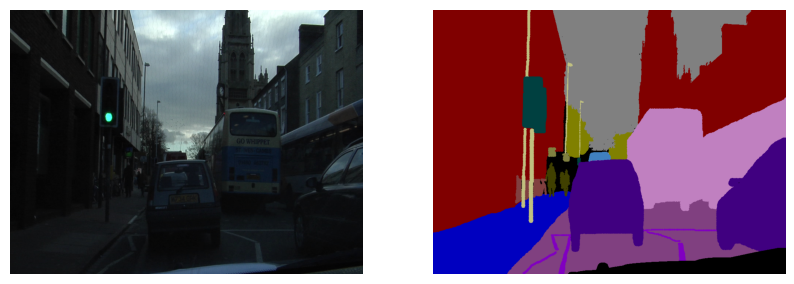

In [9]:
def show_example(idx: int) -> None:
    dataset = SegmentationDataset(data_root, skip_transform_cache=True)
    img, sgm = dataset[idx]
    print(img.shape, sgm.shape, img.dtype, sgm.dtype)
    image = v2.ToPILImage()(img)
    sgm_image = v2.ToPILImage()(sgm)
    sgm_image.putpalette(dataset.get_pallete())

    fig, ax = plt.subplots(1,2, figsize=(10, 20), squeeze=True)
    ax[0].imshow(image)
    ax[1].imshow(sgm_image)
    ax[0].axis("off")
    ax[1].axis("off")

show_example(0)

## Training config

In [10]:
batch_size = 50
test_batch_size = 1000
epochs = 15
lr = 2e-3
seed = 1
log_interval = 10
test_size = 80

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]
num_classes = 32

# Check for CUDA / MPS (Apple) / XPU (Intel) / ... accelerator.
# This does not detect XLA devices (Google TPUs), they'd need separate checks.
device = torch.accelerator.current_accelerator(check_available=True) or torch.device("cpu")
use_accel = device != torch.device("cpu")
print(use_accel, device)

True cuda


In [11]:
class DataloaderArgs(TypedDict, total=False):
    batch_size: int
    shuffle: bool
    num_workers: int
    pin_memory: bool

train_kwargs: DataloaderArgs = {"batch_size": batch_size, "num_workers": 0, "shuffle": True, "pin_memory": use_accel}
test_kwargs: DataloaderArgs = {"batch_size": test_batch_size, "num_workers": 0, "pin_memory": use_accel}

## Training

In [12]:
torch.manual_seed(seed)

input_transform = v2.Compose(
    [
        v2.Resize((240, 320)),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(imagenet_mean, imagenet_std),
    ]
)

segmentation_transform = v2.Compose(
    [
        v2.Resize((240, 320), interpolation=InterpolationMode.NEAREST),
        v2.PILToTensor(),
        v2.ToDtype(torch.long, scale=False),
    ]
)

full_dataset = SegmentationDataset(
    data_root,
    transform=input_transform,
    target_transform=segmentation_transform,
)

full_indices = list(range(len(full_dataset)))
train_indices = full_indices[:-test_size]
test_indices = full_indices[-test_size:]

train_dataset = torch.utils.data.Subset(full_dataset, train_indices)
test_dataset = torch.utils.data.Subset(full_dataset, test_indices)

train_loader = torch.utils.data.DataLoader(train_dataset, **train_kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, **train_kwargs)

In [13]:
model = UNet(
    encoder_channels=[3, 8, 16, 32],
    decoder_channels=[32, 16, 8],
    num_classes=num_classes,
).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch, log_interval)
    test(model, device, test_loader)

Epoch 1: 100%|██████████| 13/13 [00:16<00:00,  1.28s/it, loss=2.71]


Train accuracy: 9300576/47692800 (19.5%)
Test loss: 2.9263, accuracy: 1821615/6144000 (29.6%)


Epoch 2: 100%|██████████| 13/13 [00:03<00:00,  4.05it/s, loss=1.83]


Train accuracy: 23378792/47692800 (49.0%)
Test loss: 1.7483, accuracy: 3277188/6144000 (53.3%)


Epoch 3: 100%|██████████| 13/13 [00:03<00:00,  4.00it/s, loss=1.41]


Train accuracy: 27706803/47692800 (58.1%)
Test loss: 1.3685, accuracy: 4047147/6144000 (65.9%)


Epoch 4: 100%|██████████| 13/13 [00:03<00:00,  4.05it/s, loss=1.25]


Train accuracy: 30256897/47692800 (63.4%)
Test loss: 1.2495, accuracy: 4188369/6144000 (68.2%)


Epoch 5: 100%|██████████| 13/13 [00:03<00:00,  4.06it/s, loss=1.2]


Train accuracy: 31896985/47692800 (66.9%)
Test loss: 1.1099, accuracy: 4416513/6144000 (71.9%)


Epoch 6: 100%|██████████| 13/13 [00:03<00:00,  4.06it/s, loss=1.12]


Train accuracy: 32926875/47692800 (69.0%)
Test loss: 1.0056, accuracy: 4523720/6144000 (73.6%)


Epoch 7: 100%|██████████| 13/13 [00:03<00:00,  4.05it/s, loss=0.994]


Train accuracy: 33487618/47692800 (70.2%)
Test loss: 0.9883, accuracy: 4535631/6144000 (73.8%)


Epoch 8: 100%|██████████| 13/13 [00:03<00:00,  4.04it/s, loss=1.01]


Train accuracy: 34228998/47692800 (71.8%)
Test loss: 1.0251, accuracy: 4464647/6144000 (72.7%)


Epoch 9: 100%|██████████| 13/13 [00:03<00:00,  4.04it/s, loss=1.17] 


Train accuracy: 33287533/47692800 (69.8%)
Test loss: 1.3134, accuracy: 3961164/6144000 (64.5%)


Epoch 10: 100%|██████████| 13/13 [00:03<00:00,  4.06it/s, loss=1.14]


Train accuracy: 33280870/47692800 (69.8%)
Test loss: 0.9346, accuracy: 4624652/6144000 (75.3%)


Epoch 11: 100%|██████████| 13/13 [00:03<00:00,  4.05it/s, loss=1.02]


Train accuracy: 33915964/47692800 (71.1%)
Test loss: 0.9260, accuracy: 4683845/6144000 (76.2%)


Epoch 12: 100%|██████████| 13/13 [00:03<00:00,  4.09it/s, loss=0.961]


Train accuracy: 34576488/47692800 (72.5%)
Test loss: 0.8474, accuracy: 4784547/6144000 (77.9%)


Epoch 13: 100%|██████████| 13/13 [00:03<00:00,  4.08it/s, loss=0.937]


Train accuracy: 34788511/47692800 (72.9%)
Test loss: 0.8475, accuracy: 4802982/6144000 (78.2%)


Epoch 14: 100%|██████████| 13/13 [00:03<00:00,  4.08it/s, loss=1]    


Train accuracy: 35301152/47692800 (74.0%)
Test loss: 0.9102, accuracy: 4668318/6144000 (76.0%)


Epoch 15: 100%|██████████| 13/13 [00:03<00:00,  4.08it/s, loss=0.788]


Train accuracy: 35745106/47692800 (74.9%)
Test loss: 0.8687, accuracy: 4749920/6144000 (77.3%)


## Show some results

In [14]:
unnormalize = v2.Normalize(
    mean=tuple(-m / s for m, s in zip(imagenet_mean, imagenet_std)),
    std=tuple(1.0 / s for s in imagenet_std),
)

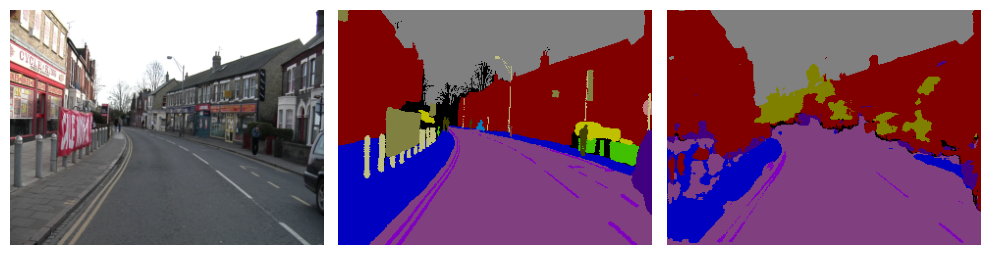

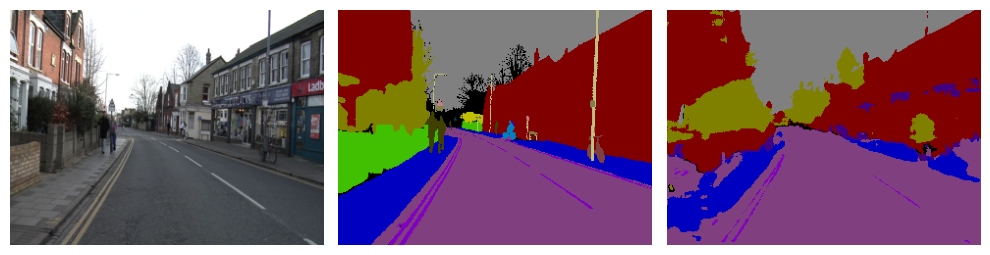

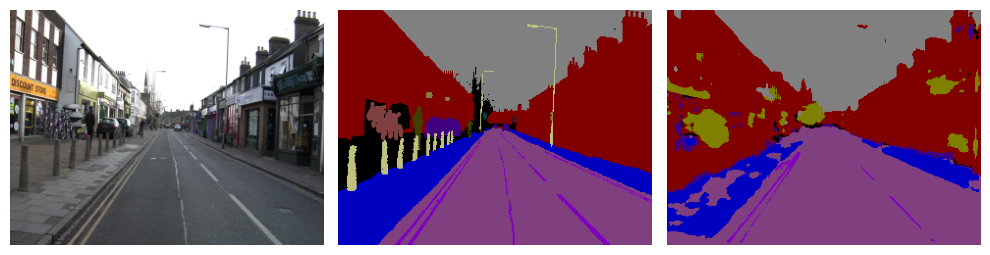

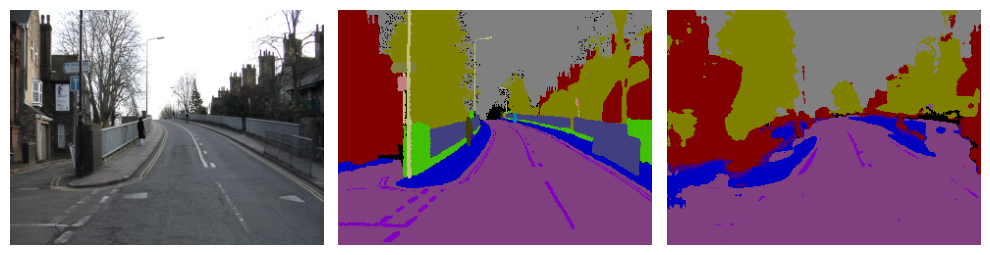

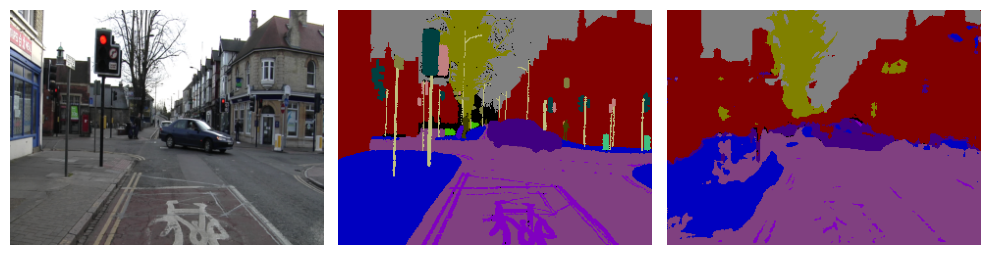

In [15]:
images, targets = next(iter(test_loader))
output = model(images.to(device))
preds = output.argmax(dim=1, keepdim=True).to("cpu")

for i in range(5):
    image = v2.ToPILImage()(unnormalize(images[i]))
    target = PIL.Image.fromarray(targets[i].squeeze(0).numpy().astype(np.uint8))
    target.putpalette(full_dataset.get_pallete())
    pred = PIL.Image.fromarray(preds[i].squeeze().numpy().astype(np.uint8))
    pred.putpalette(full_dataset.get_pallete())

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 30), squeeze=True)
    for ax, img in zip(axes, [image, target, pred]):
        ax.imshow(img)
        ax.axis("off")

    plt.tight_layout()
    plt.show()